# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Step I: Data Loading

We will find the explanation of each variable in each file:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [2]:
portfolio.sample(10)


,channels,difficulty,duration,id,offer_type,reward
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10


In [3]:
portfolio.shape

(10, 6)

In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes



We will find the explanation of each variable in each file:

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income


In [5]:
profile.sample(10)

,age,became_member_on,gender,id,income
1508,48,20180713,F,8c3c10f681674fd798b5957060bbf302,46000.0
8288,67,20170919,M,3762aacc8c144385a1d58a9fe2317af2,62000.0
12064,77,20170807,F,c99f2747263b49b695a55e324d1a2c9a,58000.0
9338,51,20171125,F,daabbe6246ef4472a2a579a3b246b43c,41000.0
8113,53,20180607,F,c9a2482aa3b44ad18e033a37a37fdaca,54000.0
10823,118,20180426,None,fb94c0d3247b41adb00d6a46b4603fe8,NaN
15642,56,20171206,M,9c02b46ea37b4f489ab38565f865f9c6,63000.0
12557,64,20171017,M,4b72d9b8182f45f0bef5758ffbc3c1eb,65000.0
418,118,20150822,None,901e3bdd943244ccb87af0ed7dcf0680,NaN
9151,21,20171020,M,50d8a688a88b41b195c73d0d1a85633f,41000.0


In [6]:
profile.shape

(17000, 5)


**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [7]:
transcript.sample(10)

,event,person,time,value
253664,offer received,7ad57acd1d7c46ce8972d2661b46e395,576,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
212336,offer received,6b64bd90a25b4c1399eb9f6e29a4d6f4,504,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
262860,offer viewed,6994d35034504f6caeacc956d95b3eaa,582,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
211040,offer received,4fb65757dc0c48e19008422711af52ba,504,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
103115,transaction,997938e130bc4607a3649456a13d26a2,288,{'amount': 38.96}
305527,transaction,9e64ffbc7e3f413ebfb9aae9bb893c49,714,{'amount': 15.0}
257186,offer received,ddc82116e8c844a18894eab1c8e5a596,576,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
33509,transaction,b509c1c707b7455fa6e8e39bd232e9c3,60,{'amount': 1.11}
229013,offer viewed,da653fa452914b2eb9cfc4a8ed5c9b4b,528,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
226025,transaction,4ebf3a190a1848119826a7e2ed3cbcc1,522,{'amount': 5.38}


In [8]:
transcript.shape

(306534, 4)

# Step II: Data Wrangling (portfolio table)


In this part, we want to fix issues in some columns, such as a **channel** in the **portfolio table** and **value in the transcript table**
- split type of channel into the different attributes

In [9]:
# extract all channels
set_of_channels = set()
for channel in portfolio['channels']:
    set_of_channels.update(set(channel))
#split channels in differents columns
for channel in set_of_channels:
    portfolio[channel] = portfolio.channels.apply(lambda x: channel in x).map({True:1, False: 0})
portfolio.drop('channels', axis = 1, inplace=True) # remove channels column

In [10]:
portfolio.sample(3)

,difficulty,duration,id,offer_type,reward,social,mobile,web,email
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,0,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0,1,1,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,0,1,1


In [11]:
portfolio.isna().sum()

difficulty    0
duration      0
id            0
offer_type    0
reward        0
social        0
mobile        0
web           0
email         0
dtype: int64

In [12]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [13]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [14]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [15]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


# Data Wrangling (profile table):

   - In **gender and income** attribute we have some NaN values, we will fill NaN with N/A for **gender** and I will fill NaN with mode for **income**.

- In **age** attribute we have noticed there is outliers values in age attributes such as 101 and 118, that impossible as age's value, so we will drop *age values that greater than 95.

- We should convert the data type of **become_member_on** attribute to datetime, then split this column to **became_member_year and became_member_month**.

In [16]:
#dealing with null values 
profile['gender'].fillna('N/A', inplace=True)
mean_income = profile.income.mean() 
profile['income'].fillna(mean_income, inplace = True)
#profile['income'].fillna((profile.income.mode()[0]), inplace=True)

In [17]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              17000 non-null object
id                  17000 non-null object
income              17000 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [18]:
#make sure age column is a numeric datatype
#profile['age'] = profile['age'].apply(pd.to_numeric, errors='coerce')


In [19]:
#check for age 118

profile[['gender', 'income', 'age']][profile.age>95].sample(10)

,gender,income,age
4480,N/A,65404.991568,118
14320,N/A,65404.991568,118
380,N/A,65404.991568,118
1188,N/A,65404.991568,118
16316,N/A,65404.991568,118
4470,N/A,65404.991568,118
8457,N/A,65404.991568,118
7938,N/A,65404.991568,118
10830,N/A,65404.991568,118
8071,N/A,65404.991568,118


In [20]:
#replace 118 age with N/A 
#profile['age'].replace([118], ['N/A'], inplace=True)

In [21]:
#age_eql_118 = profile[['gender', 'income','age']][profile.age==118]
#age_eql_118

In [22]:
#remove extream values from age attribute
profile.drop(profile.query('(age >95)').index, inplace=True)


In [23]:
#profile.drop(profile.query('(gender == "N/A")').index, inplace=True)


In [24]:
profile.sample(5)

,age,became_member_on,gender,id,income
5356,59,20161230,F,aed8e306eb214dc4991026c1005bff46,89000.0
16194,57,20150812,M,3622ada8c6394b32a8d7ba31c737e926,111000.0
4217,47,20150810,F,6c2c85ad5b244122a70425e6be34e0fd,30000.0
2008,74,20161019,M,9b0841c814534f23bf691f4a68f92f1a,78000.0
1160,54,20160525,F,f433cff29e324685ae74dd8488ee34bd,53000.0


- **Here we will convert the data type of *become_member_on* attribute to datetime**.
- **Then split the column to year and month**.

In [25]:
# convert the datatype into datetime
profile["became_member_on"] = pd.to_datetime(profile.became_member_on.apply(str))

# split the data after '-' in year column to year
profile['became_member_year'] = profile['became_member_on'].apply(lambda x: x.year)

#split the data after '-' in month column to month
profile['became_member_month'] = profile['became_member_on'].apply(lambda x: x.month)


In [26]:
profile = profile.drop('became_member_on', axis=1)


In [27]:
#check for null values
profile.isnull().sum()


age                    0
gender                 0
id                     0
income                 0
became_member_year     0
became_member_month    0
dtype: int64

# Data Wrangling (transcript table):

   - We will split value attribute into different attributes which are: offer_id, reward, and amount to make it clear for analyzing.
   
- Then we will remove the value's column.


In [28]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [29]:
transcript.isnull().sum()


event     0
person    0
time      0
value     0
dtype: int64

In [30]:
transcript_ = transcript.copy()

In [31]:
transcript_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [32]:
# extract all values
set_of_values = set()
for values in transcript['value']:
    set_of_values.update(set(values))


In [33]:
set_of_values

{'amount', 'offer id', 'offer_id', 'reward'}

In [34]:
transcript = transcript[transcript['value'].apply(lambda x: True if ('offer id' in x) or ('offer_id' in x) else False)]
    
# extract the offer id from value column
transcript['offer_id'] = transcript['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])

for i in ["amount", "reward"]:
    transcript[i] = transcript.value.apply(lambda x: x[i] if i in x else 0)

In [35]:
transcript = transcript.drop('value', axis=1)
transcript.head()

,event,person,time,offer_id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0



   In this part we will merge table Profile with Transcript.
   

In [36]:
#merge table
df_combined_1= transcript.merge(profile, left_on='person', right_on='id', how='inner')


we will remove duplicated values at Id column.


In [37]:
df_combined_1.drop_duplicates(['id'], keep='last', inplace=True)

In [38]:
df_combined_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14772 entries, 10 to 148300
Data columns (total 12 columns):
event                  14772 non-null object
person                 14772 non-null object
time                   14772 non-null int64
offer_id               14772 non-null object
amount                 14772 non-null int64
reward                 14772 non-null int64
age                    14772 non-null int64
gender                 14772 non-null object
id                     14772 non-null object
income                 14772 non-null float64
became_member_year     14772 non-null int64
became_member_month    14772 non-null int64
dtypes: float64(1), int64(6), object(5)
memory usage: 1.5+ MB



Then we will merge Transcript table with Protfolio.   

In [39]:
#merge tables
df_combined_2 = transcript.merge(portfolio, left_on ='offer_id', right_on='id', how = 'inner')

In [40]:
#merge the tables
dfs_combined= df_combined_2.merge(df_combined_1, left_on ='person', right_on='id', how = 'inner')

In [41]:
pd.set_option('display.max_rows', None)

In [42]:
#remove use less columns
dfs_combined.drop(dfs_combined.columns[[5, 10, 15, 16, 17, 18, 19, 23]], axis=1, inplace=True)

In [43]:
#Fix columns name
dfs_combined.rename(columns={"event_x":"event", "person_x":"person","time_x":"time","offer_id_x":"offer_id","amount_x":"amount",
                             "id_x": "id"}, inplace =True)

In [44]:
dfs_combined.head()

,event,person,time,offer_id,amount,difficulty,duration,id,offer_type,social,mobile,web,email,reward,age,gender,income,became_member_year,became_member_month
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,0,1,1,1,0,75,F,100000.0,2017,5
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,0,1,1,1,0,75,F,100000.0,2017,5
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,0,1,1,1,0,75,F,100000.0,2017,5
3,offer received,78afa995795e4d85b5d9ceeca43f5fef,504,f19421c1d4aa40978ebb69ca19b0e20d,0,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,1,1,1,1,0,75,F,100000.0,2017,5
4,offer completed,78afa995795e4d85b5d9ceeca43f5fef,510,f19421c1d4aa40978ebb69ca19b0e20d,0,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,1,1,1,1,0,75,F,100000.0,2017,5


In [45]:
#remove duplicated values
#dfs_combined.drop_duplicates(['person'], keep='last', inplace=True)

In [46]:
dfs_combined.describe()


,time,amount,difficulty,duration,social,mobile,web,email,reward,age,income,became_member_year,became_member_month
count,148301.000000,148301.0,148301.000000,148301.000000,148301.000000,148301.000000,148301.000000,148301.0,148301.000000,148301.000000,148301.000000,148301.000000,148301.000000
mean,354.561439,0.0,7.890163,6.625228,0.658370,0.917155,0.806623,1.0,2.270544,54.631338,66380.078354,2016.575674,6.705275
std,198.305653,0.0,5.041603,2.133090,0.474258,0.275649,0.394947,0.0,3.128100,17.033793,21489.214234,1.187295,3.495039
min,0.000000,0.0,0.000000,3.000000,0.000000,0.000000,0.000000,1.0,0.000000,18.000000,30000.000000,2013.000000,1.000000
25%,168.000000,0.0,5.000000,5.000000,0.000000,1.000000,1.000000,1.0,0.000000,43.000000,51000.000000,2016.000000,4.000000
50%,408.000000,0.0,10.000000,7.000000,1.000000,1.000000,1.000000,1.0,0.000000,56.000000,65000.000000,2017.000000,7.000000
75%,510.000000,0.0,10.000000,7.000000,1.000000,1.000000,1.000000,1.0,5.000000,67.000000,81000.000000,2017.000000,10.000000
max,714.000000,0.0,20.000000,10.000000,1.000000,1.000000,1.000000,1.0,10.000000,95.000000,120000.000000,2018.000000,12.000000


# Visualizing and modeling part:

  

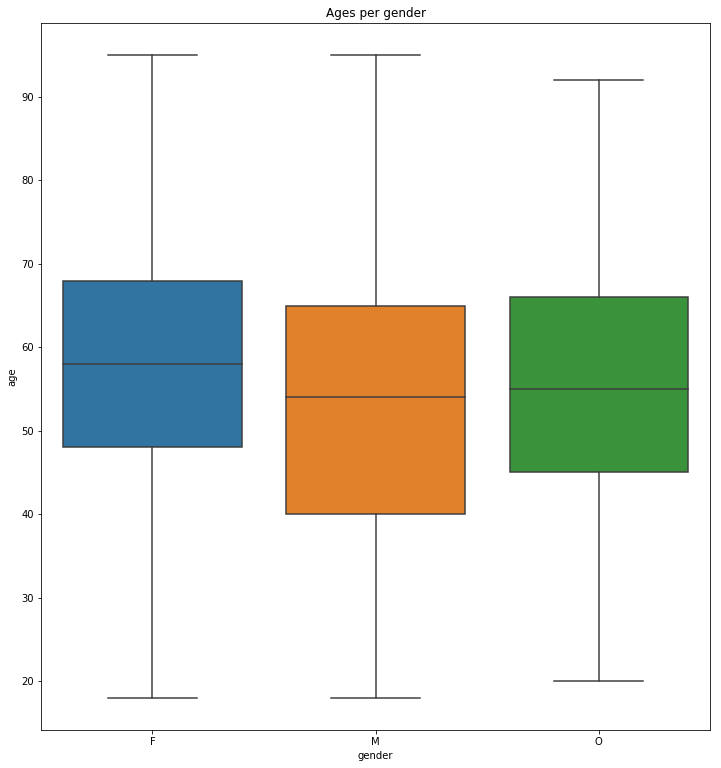

In [47]:
import seaborn as sns 
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize']=(12,13)
sns.boxplot(x="gender", y="age", data=dfs_combined).set_title('Ages per gender');




-  ### **As we can notice from the chart the most of the ages in the profile data frame are among 35 and 70 for, and the median in the female is 58 approximately, 55 for male and other.**


In [48]:
#income per age
#ages= dfs_combined.groupby(['age'])['income'].mean()
#ages.sort_values()

In [49]:
#fig = plt.figure(figsize=(12,6))
#plt.hist(ages)
#fig.suptitle('Total of ages and incomes')
#plt.xlabel('count of ages')
#plt.ylabel('count of incomes')
#plt.show();

In [50]:
dfs_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148301 entries, 0 to 148300
Data columns (total 19 columns):
event                  148301 non-null object
person                 148301 non-null object
time                   148301 non-null int64
offer_id               148301 non-null object
amount                 148301 non-null int64
difficulty             148301 non-null int64
duration               148301 non-null int64
id                     148301 non-null object
offer_type             148301 non-null object
social                 148301 non-null int64
mobile                 148301 non-null int64
web                    148301 non-null int64
email                  148301 non-null int64
reward                 148301 non-null int64
age                    148301 non-null int64
gender                 148301 non-null object
income                 148301 non-null float64
became_member_year     148301 non-null int64
became_member_month    148301 non-null int64
dtypes: float64(1), int64(

In [51]:
result = dfs_combined.groupby(["age"])['income'].aggregate(np.median).reset_index().sort_values('age')


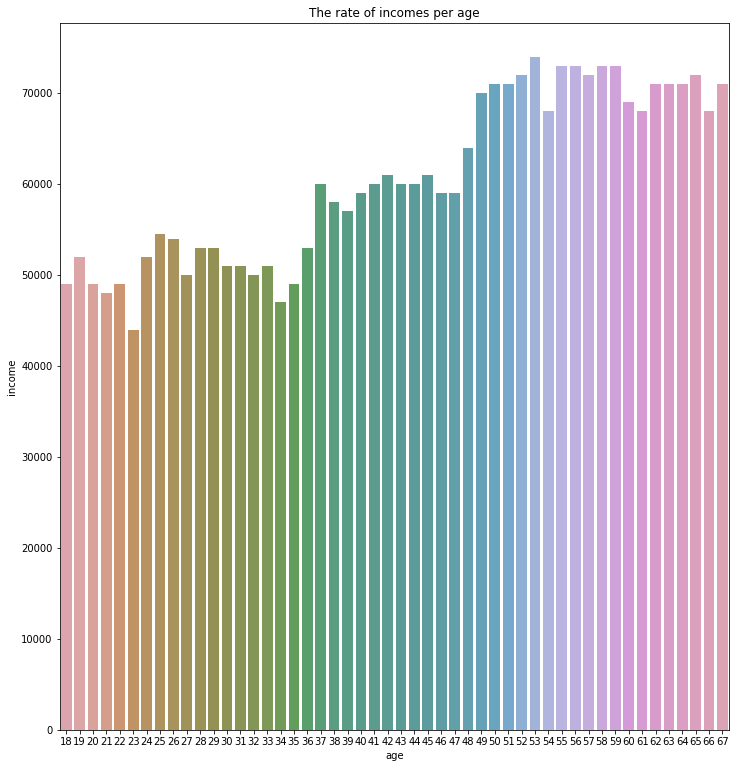

In [52]:
sns.barplot(y='income', x='age' ,data=result[:50], saturation=.5).set_title('The rate of incomes per age');


 -  ### **From the previous chart, we can say that 49, 51, 52, and 64 recorded the highest rate of incomes as an adult and elderly with approximately 70000, in the other hand, 23 and 34 recorded the lowest income rate with approximately 40500.**

In [53]:
#dfs_combineds.drop(dfs_combineds.columns[[7]], axis=1, inplace=True)

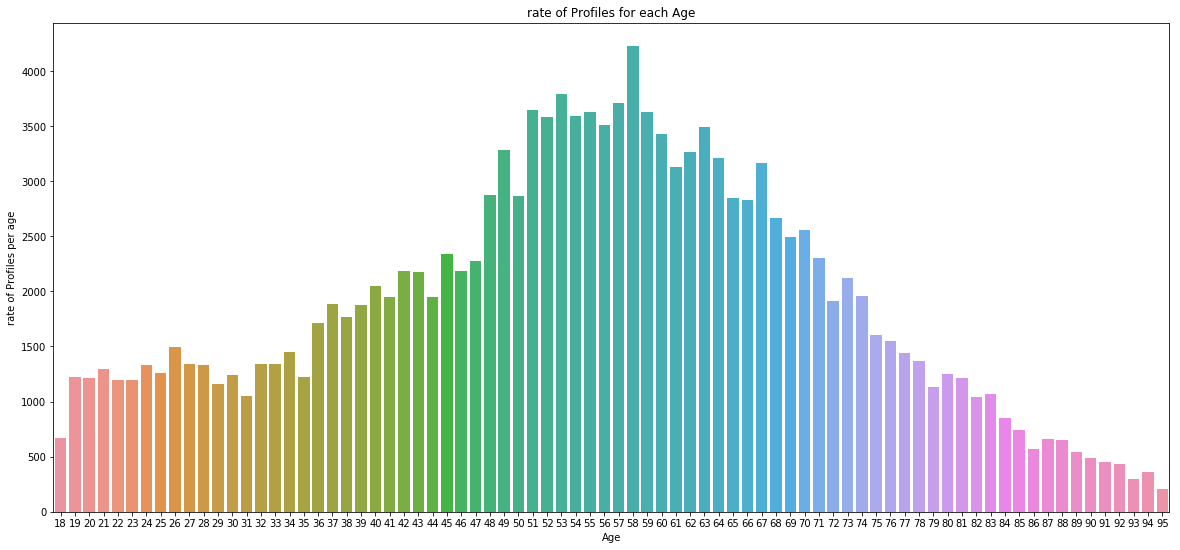

In [54]:

plt.figure(figsize=(20, 9))
sns.countplot(dfs_combined['age'], saturation=.8)
plt.title('rate of Profiles for each Age')
plt.ylabel('rate of Profiles per age')
plt.xlabel('Age')
plt.show();


 -  ### **In the previous chart, we want to find the age group that has the highest rate of profile. we can say that the elderly age group has the lowest rate for having a profile, then youth group. On the other hand, the adult age group recorded the highest rate of 4000 number of profiles.**

In [55]:
rate_of_profile_per_month =dfs_combined.groupby('became_member_month').sum().income/100
rate_of_profile_per_month

became_member_month
1     8768520.0
2     6821790.0
3     7406930.0
4     7467770.0
5     7663600.0
6     7370520.0
7     7755270.0
8     9562730.0
9     8793740.0
10    9235650.0
11    8361430.0
12    9234370.0
Name: income, dtype: float64

In [56]:
rate_of_profile_per_year =dfs_combined.groupby('became_member_year').sum().income/100
rate_of_profile_per_year

became_member_year
2013     1587710.0
2014     3898720.0
2015    11376630.0
2016    23097490.0
2017    37237600.0
2018    21244170.0
Name: income, dtype: float64

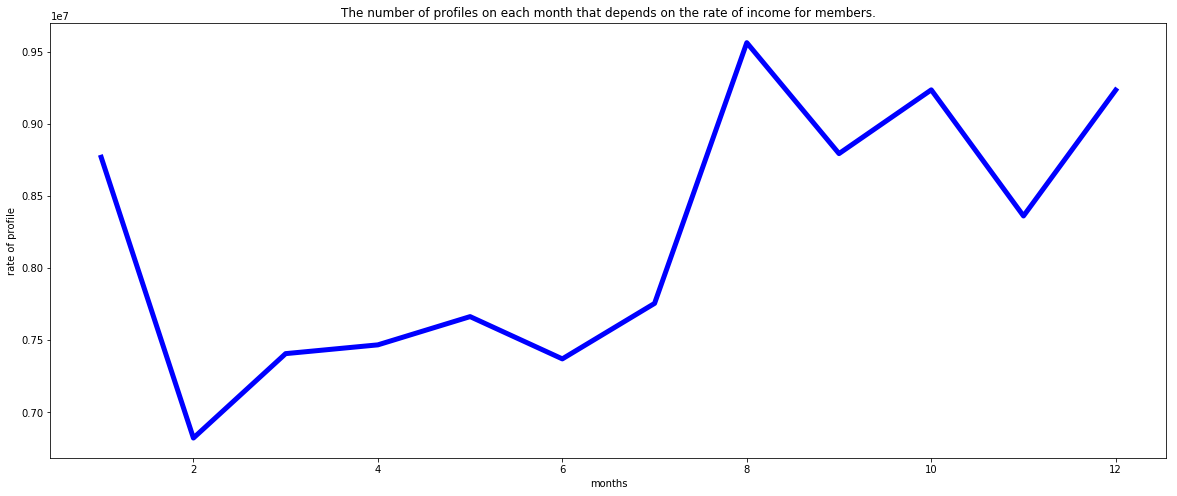

In [57]:
plt.figure(figsize=(20,8))
plt.plot(rate_of_profile_per_month, color='blue',linewidth=5)
plt.xlabel('months')
plt.ylabel('rate of profile')
plt.title('The number of profiles on each month that depends on the rate of income for members.')
plt.show;






-  ### **From the above plot, we can say that the number of profiles on each month which depends on the rate of income for members, was suddenly increased and decreased on each month. Furthermore, we can note that most rates of new profiles occurred in Aug with  9562730.0 profiles approximately, and the lowest rate occurred in the month of Feb.**

In [58]:
rate_of_rewards_per_year = dfs_combined.groupby('became_member_year').sum().reward
rate_of_rewards_per_year.sort_values(ascending=False)

became_member_year
2017    130008
2016     92491
2018     52696
2015     44081
2014     11739
2013      5709
Name: reward, dtype: int64

In [59]:
rate_of_rewards_per_month =dfs_combined.groupby('became_member_month').sum().reward
rate_of_rewards_per_month

became_member_month
1     32054
2     20743
3     23963
4     25107
5     24220
6     24291
7     25964
8     31547
9     32101
10    34240
11    30077
12    32417
Name: reward, dtype: int64

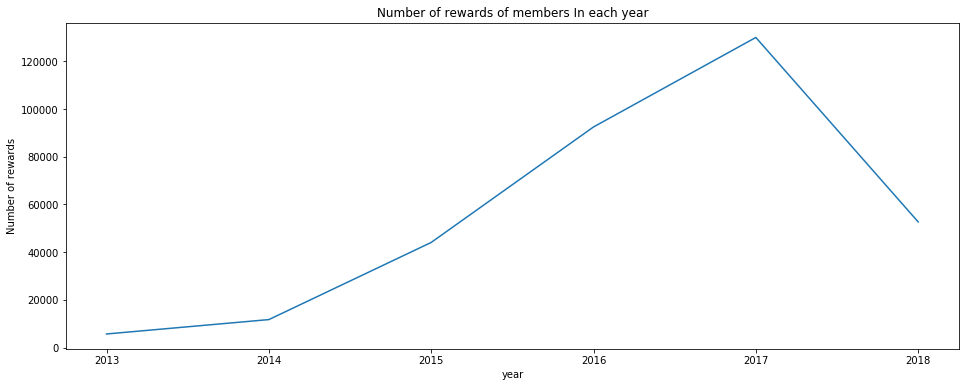

In [60]:
plt.figure(figsize=(16, 6))
plt.plot(rate_of_rewards_per_year)
plt.title('Number of rewards of members In each year')
plt.ylabel('Number of rewards')
plt.xlabel('year')
plt.show();


-  ### **As we can see from the previous plot, the rewards were increased over the years from 2013 to 2017, and we can note that the year 2017 has occurred the highest rate of rewards for members. However, it was suddenly decreased in 2018.**

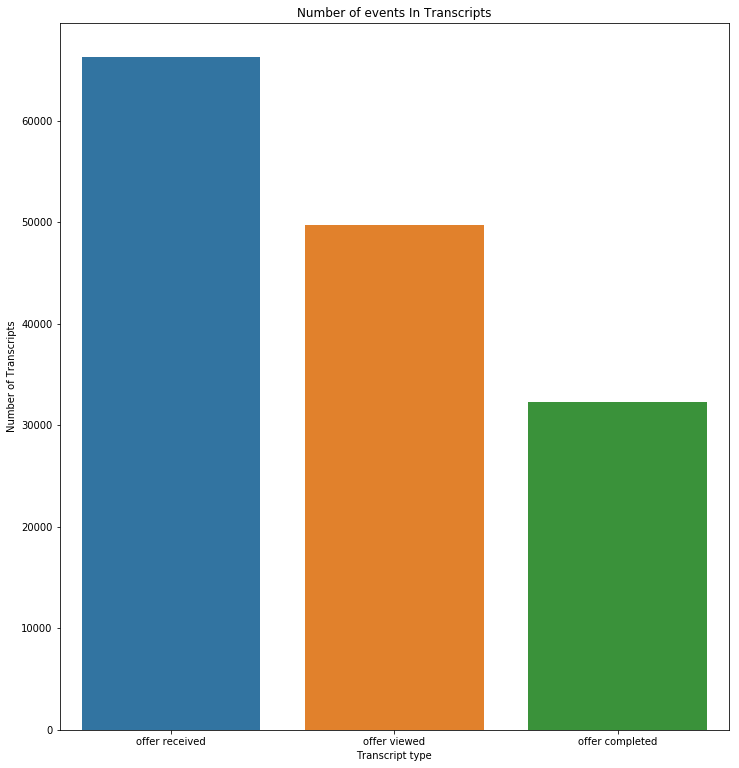

In [61]:
sns.countplot(dfs_combined['event'])
plt.title('Number of events In Transcripts')
plt.ylabel('Number of Transcripts')
plt.xlabel('Transcript type')
plt.show();


-  ### **As we can see from the above plot, the rate of events In transcripts recorded the highest rate in the type of offer which is (offer recived) with 70000 approximately, then offer viewed then offer completed.**

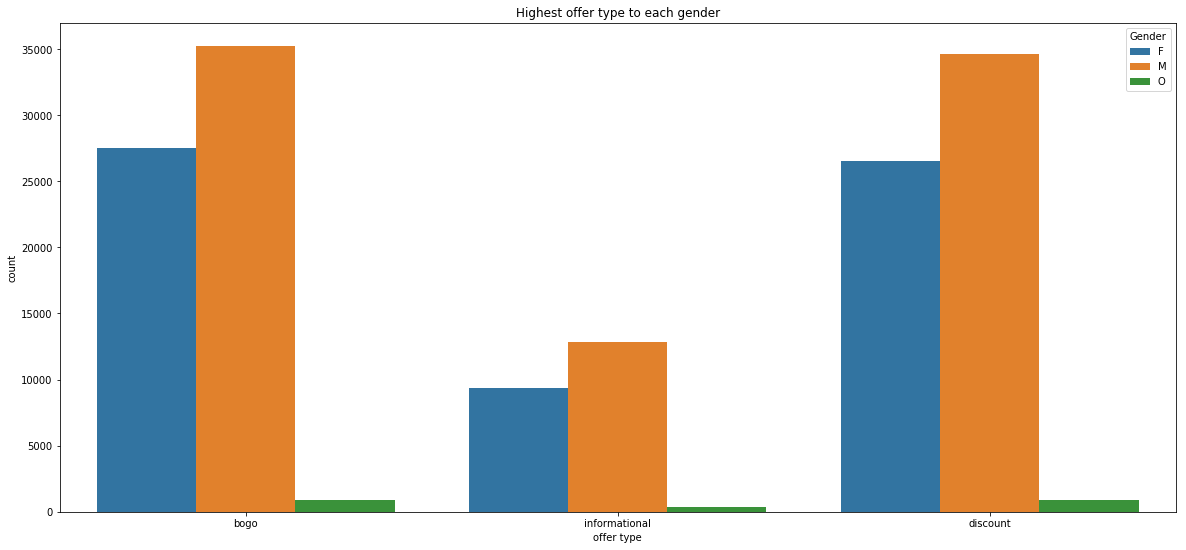

In [62]:
plt.figure(figsize=(20, 9))
sns.countplot(x=dfs_combined.offer_type, hue="gender", data=dfs_combined)
plt.title('Highest offer type to each gender')
plt.ylabel('count')
plt.xlabel('offer type')
plt.legend(title='Gender')
plt.show();


-  ### *As we can find from the previous plot, males record the highest number of using BOGO and Discount promotions with approximately 35000. In comparison, females recorded the lowest rate of using promotions with approximately 27000  for BOGO and Discount promotions*

In [63]:
dfs_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148301 entries, 0 to 148300
Data columns (total 19 columns):
event                  148301 non-null object
person                 148301 non-null object
time                   148301 non-null int64
offer_id               148301 non-null object
amount                 148301 non-null int64
difficulty             148301 non-null int64
duration               148301 non-null int64
id                     148301 non-null object
offer_type             148301 non-null object
social                 148301 non-null int64
mobile                 148301 non-null int64
web                    148301 non-null int64
email                  148301 non-null int64
reward                 148301 non-null int64
age                    148301 non-null int64
gender                 148301 non-null object
income                 148301 non-null float64
became_member_year     148301 non-null int64
became_member_month    148301 non-null int64
dtypes: float64(1), int64(

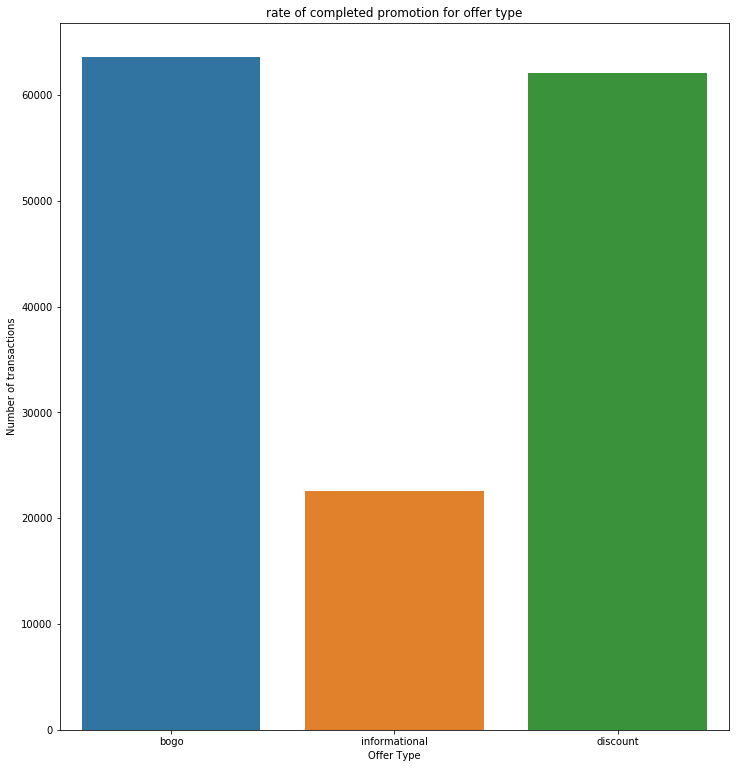

In [64]:
sns.countplot(dfs_combined['offer_type'])
plt.title('rate of completed promotion for offer type')
plt.ylabel('Number of transactions')
plt.xlabel('Offer Type')
plt.show();


-  ### **The previous chart illustrates the BOGO and Discount offer type recorded the highest number of rate of completed promotion, then Informational with the lowest rate.**

In [65]:
completed_bogo_offer = dfs_combined.query('(event == "offer completed" and offer_type == "bogo")')

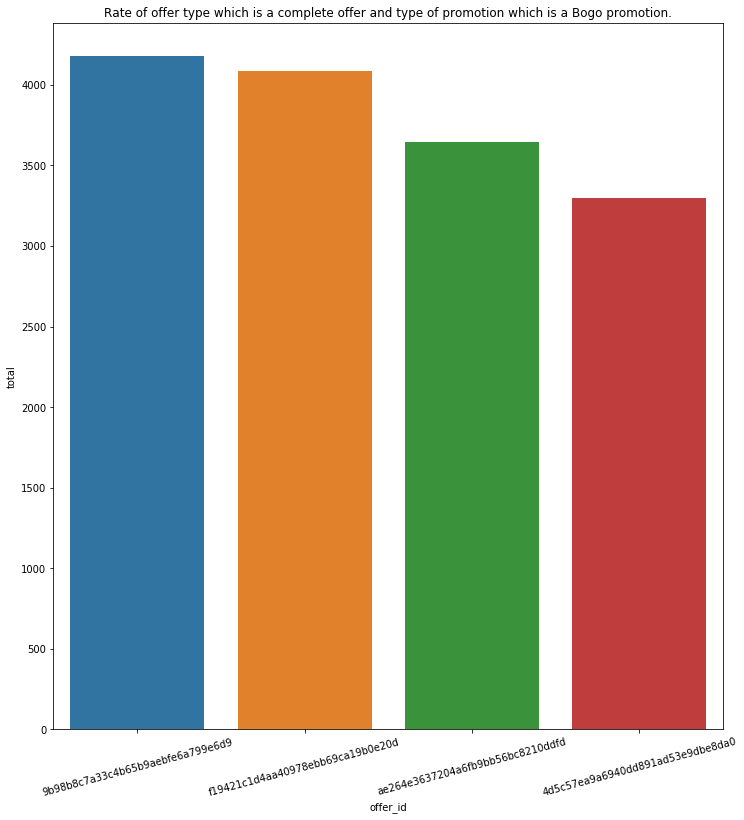

In [66]:
sns.countplot(x=completed_bogo_offer['offer_id'])
plt.title('Rate of offer type which is a complete offer and type of promotion which is a Bogo promotion.')
plt.ylabel('total')
plt.xticks(rotation = 15)
plt.show();


-  ### **From the above plot, the rate of offer type which is a Complete Offer and type of promotion which is a Bogo, we can say that the offer Id: (9b98b8c7a33c4b65b9aebfe6a799e6d9) has approximately 4200 number of completions.**

In [67]:
completed_discount_offer = dfs_combined.query('(event == "offer completed" and offer_type == "discount")')

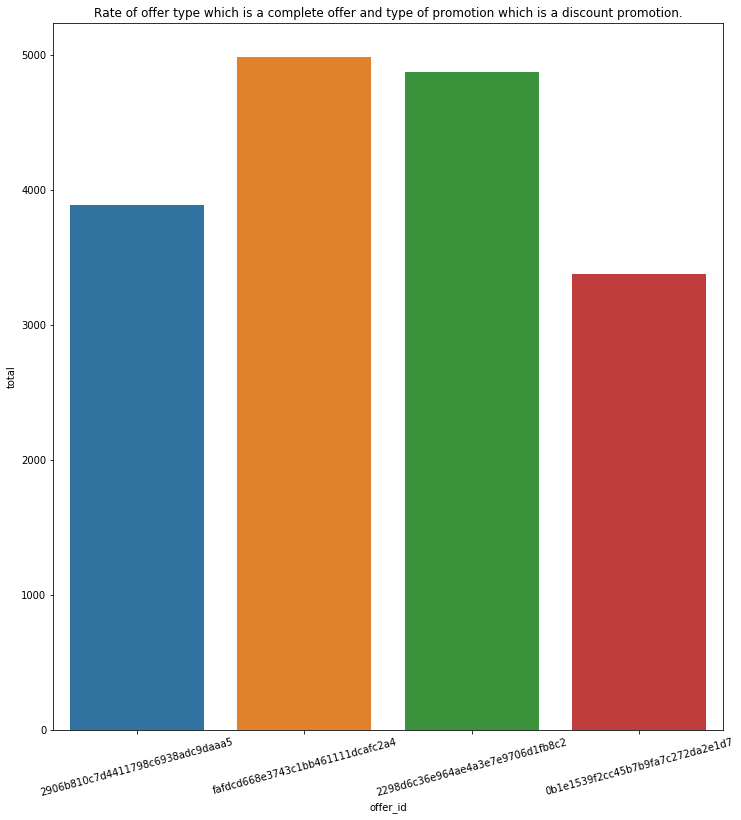

In [68]:
sns.countplot(x=completed_discount_offer['offer_id'])
plt.title('Rate of offer type which is a complete offer and type of promotion which is a discount promotion.')
plt.ylabel('total')
plt.xticks(rotation = 15)
plt.show();



-  ### **From the above plot, the rate of offer type which is a Complete Offer and type of promotion which is a Discount, we can say that the offer Id: (fafdcd668e3743c1bb461111dcafc2a4) has approximately 4900 number of completions.**

In [69]:
#completed_offer_male = dfs_combined.query('(event == "offer completed" and gender == "F")')
#print(completed_offer_male.shape[0])

In [70]:
#completed_offer_male = dfs_combined.query('(event == "offer completed" and gender == "M")')
#print(completed_offer_male.shape[0])

In [71]:
#sns.countplot(x=completed_offer_female['offer_id'])
#plt.title('Rate of offer type which is a complete offer and type of promotion which is a discount promotion.')
#plt.ylabel('total')
#plt.xticks(rotation = 15)
#plt.show();


## Training models and improvements:

In [72]:
pd.set_option('display.max_columns', None)

In [73]:
# One Hot Encoding
one_hot_columns = ['event','gender']
dfs_combined = pd.get_dummies(dfs_combined, columns=one_hot_columns, prefix = one_hot_columns)

In [74]:
dfs_combined.head()

,person,time,offer_id,amount,difficulty,duration,id,offer_type,social,mobile,web,email,reward,age,income,became_member_year,became_member_month,event_offer completed,event_offer received,event_offer viewed,gender_F,gender_M,gender_O
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,0,1,1,1,0,75,100000.0,2017,5,0,1,0,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,0,1,1,1,0,75,100000.0,2017,5,0,0,1,1,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,0,1,1,1,0,75,100000.0,2017,5,1,0,0,1,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,504,f19421c1d4aa40978ebb69ca19b0e20d,0,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,1,1,1,1,0,75,100000.0,2017,5,0,1,0,1,0,0
4,78afa995795e4d85b5d9ceeca43f5fef,510,f19421c1d4aa40978ebb69ca19b0e20d,0,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,1,1,1,1,0,75,100000.0,2017,5,1,0,0,1,0,0



-  we will replace offer types to **1 for BOGO**, **2 for discount**, **3 for Informational**.

In [75]:
dfs_combined['offer_type'].replace(['bogo','discount','informational'], [1,2,3], inplace=True)

In [76]:
#'person','time','offer_id' ,'amount','difficulty' ,'duration' ,'id' ,'email','mobile' ,'social','web',
#'reward','age','income','became_member_year','became_member_month',
#'event_offer completed','event_offer received' ,'event_offer viewed','offer_type_bogo' ,'offer_type_discount',
#'offer_type_informational','gender_F','gender_M','gender_O                    

In [77]:
X = dfs_combined[['time' ,'difficulty' ,'duration' ,'email','mobile' ,'income','reward',
                 'social','web','age','income','became_member_year','became_member_month','event_offer completed',
                 'event_offer received' ,'event_offer viewed' ,'event_offer viewed','gender_F','gender_M','gender_O']]
y = dfs_combined['offer_type']

In [78]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression

# Splitinto training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [79]:
clf_A = GaussianNB()
clf_A.fit(X_train, y_train)
y_test_preds = clf_A.predict(X_test)
print('R2 = {:.4f}'.format(r2_score(y_test, y_test_preds)))
print('mean squared error =  {:.4f}'.format(mean_squared_error(y_test, y_test_preds)))
print('Accuracy of GaussianNB classifier for training set: {:.2f}'.format(clf_A.score(X_train, y_train)*100)+'%')



R2 = 0.6143
mean squared error =  0.1950
Accuracy of GaussianNB classifier for training set: 80.52%


In [80]:
clf_B = DecisionTreeClassifier()
clf_B.fit(X_train, y_train)
y_test_preds = clf_B.predict(X_test)
print('R2 = {:.4f}'.format(r2_score(y_test, y_test_preds)))
print('mean squared error =  {:.4f}'.format(mean_squared_error(y_test, y_test_preds)))
print('Accuracy of Decision Tree classifier for training set: {:.2f}'.format(clf_B.score(X_train, y_train)*100)+'%')



R2 = 1.0000
mean squared error =  0.0000
Accuracy of Decision Tree classifier for training set: 100.00%


In [81]:
clf_D = LinearRegression()
clf_D.fit(X_train, y_train)
y_test_preds = clf_D.predict(X_test)
print('R2 = {:.4f}'.format(r2_score(y_test, y_test_preds)))
print('mean squared error =  {:.4f}'.format(mean_squared_error(y_test, y_test_preds)))
print('Accuracy of LinearRegression classifier for training set: {:.2f}'.format(clf_D.score(X_train, y_train)*100)+'%')



R2 = 0.3876
mean squared error =  0.3095
Accuracy of LinearRegression classifier for training set: 38.33%


In [82]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

knn.fit(X_train, y_train)
print('R2 = {:.4f}'.format(r2_score(y_test, y_test_preds)))
print('mean squared error =  {:.4f}'.format(mean_squared_error(y_test, y_test_preds)))
print('Accuracy of KNeighborsClassifier classifier for training set: {:.2f}'.format(knn.score(X_train, y_train)*100)+'%')


R2 = 0.3876
mean squared error =  0.3095
Accuracy of KNeighborsClassifier classifier for training set: 78.89%



- ### As we can see after we using LinearRegression, DecisionTreeClassifier, and GaussianNB. Avoiding of overfitting, We can found that GaussianNB classifier is the best choice  with 80.52% accuracy result, 61% of R2 and 19% of mean squared error.


## Conclusion and :

In this project, we analyzed Starbucks customers, first of all, we start for cleaning the data, the assessment process, after that, we did data visualization to get the results from our analysis. Moreover, we found that the Male is recorded at the highest rate of Starbucks customers. The adult age group which has the highest rate of incomes have the highest rate of having a profile as s Starbucks member. Also, males recorder the highest rate using promotions especially: BOGO, and discount promotions type. Finally, we found the best model for the best offer for customers which is GaussianNB classifier with 80.52% accuracy result, 61% of R2 and 19% of mean squared error.
the metric we used is accuracy because it is often used to compare models, as it tells us the proportion of observations we correctly labeled, and (MSE) Mean squared error and R2 for evaluating the model, for optimizing a model we should have the lowest MSE and highest R2 value.

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Starbucks_Capstone_notebook.ipynb'])